<font size="8">**Data Model - Time Series**</font>

<font size="5">Initial Setup for Pyramid</font>

In [1]:
#install pyramid
!pip install pmdarima --user

<font size="5">Import Library</font>

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings
import pmdarima as pm
from pmdarima import model_selection
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
%matplotlib inline

<font size="5">Import Edited Dataset</font>

In [3]:
train_final = pd.read_csv (r'D:\Jupyter\Merged\train_final.csv')  
train_final.Date = pd.to_datetime(train_final.Date,format='%Y-%m-%d')
train_final.index = train_final.Date
train_final = train_final.drop('Date', axis=1)
train_final.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Year,Week
Date,,,,,,,,
2010-02-05,1,1,24924.50,0,3,151315,2010,5
2010-02-05,1,2,50605.27,0,3,151315,2010,5
2010-02-05,1,3,13740.12,0,3,151315,2010,5
2010-02-05,1,4,39954.04,0,3,151315,2010,5
2010-02-05,1,5,32229.38,0,3,151315,2010,5


<font size="5">Setting Training and Test Set Groupby Date</font>

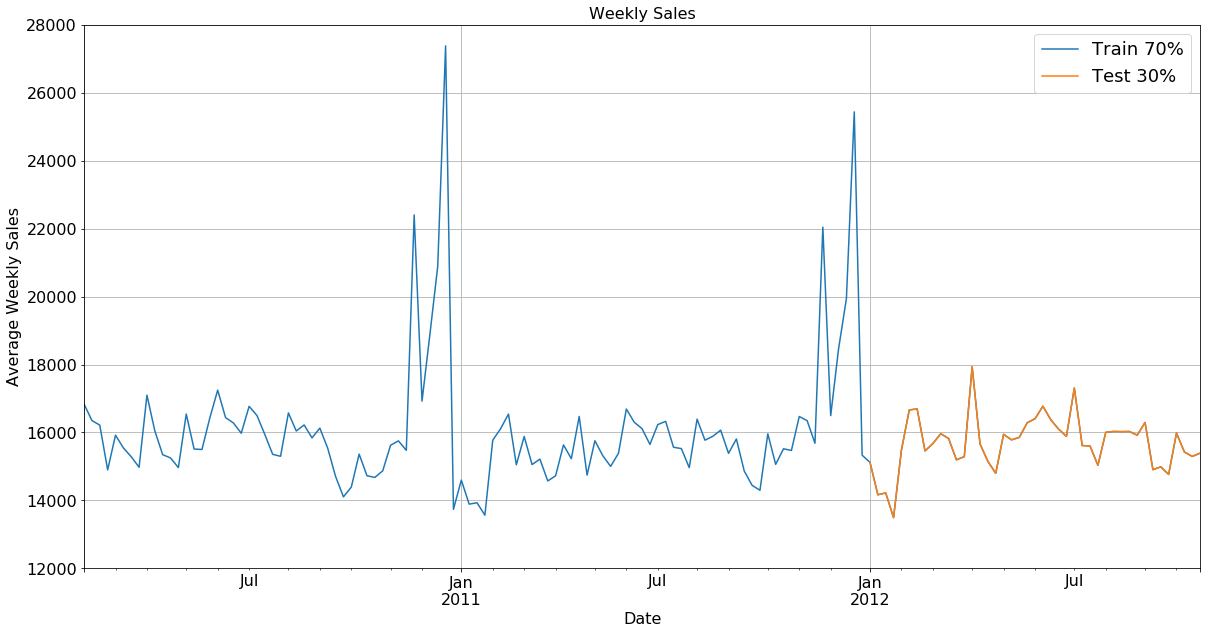

In [4]:
train_final1 = train_final.groupby(train_final.index).mean()
train_finalS=train_final1['Weekly_Sales']
train_data = train_final1[:int(0.7*(len(train_final1)))]
test_data = train_final1[int(0.7*(len(train_final1))):]

train_data = train_data['Weekly_Sales']
test_data = test_data[['Weekly_Sales','IsHoliday']]

train_final1.Weekly_Sales.plot(figsize=(20,10), title= 'Weekly_Sales', fontsize=16)
test_data.Weekly_Sales.plot(figsize=(20,10), title= 'Weekly_Sales', fontsize=16)

plt.legend(['Train 70%','Test 30%'],loc='best',fontsize=18)
plt.title('Weekly Sales',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Average Weekly Sales',fontsize=16)
plt.ylim(12000,28000)
plt.grid(True)

plt.show()

<font size="5">Decomposition of the Dataset</font>

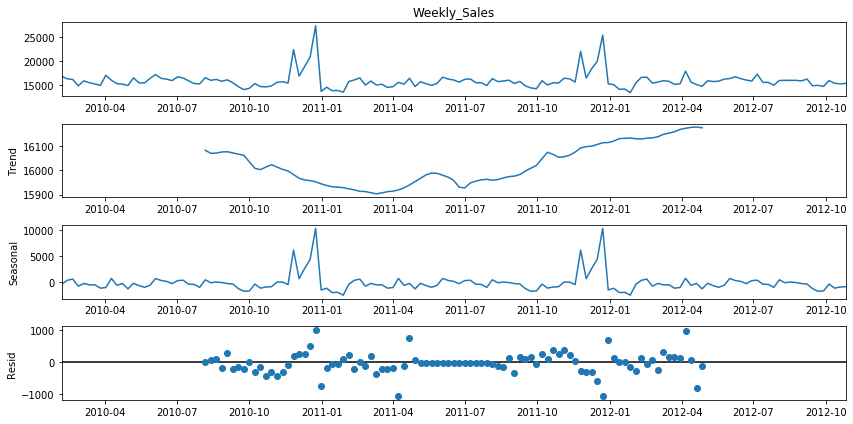

In [5]:
decomposition=seasonal_decompose(train_final1.Weekly_Sales, model= "addictive",period=52)
rcParams['figure.figsize'] = (12, 6)
fig=decomposition.plot()

This is a useful abstraction.

Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on your problem.

It provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model.

Each of these components are something you may need to think about and address during data preparation, model selection, and model tuning. You may address it explicitly in terms of modeling the trend and subtracting it from your data, or implicitly by providing enough history for an algorithm to model a trend if it may exist.

You may or may not be able to cleanly or perfectly break down your specific time series as an additive or multiplicative model.

Real-world problems are messy and noisy. There may be additive and multiplicative components. There may be an increasing trend followed by a decreasing trend. There may be non-repeating cycles mixed in with the repeating seasonality components.

Nevertheless, these abstract models provide a simple framework that you can use to analyze your data and explore ways to think about and forecast your problem.

Level: is the average value in the series.
Trend: is the increasing or decreasing value in the series.
Seasonality: is the repeating the short-term cycle in the series.
Noise: is the random variation in the series.

<font size="5">Augmented Dickey Fuller Test to Test Stationary</font>

In [6]:
X = train_final1['Weekly_Sales']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %.9f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0]<result[4]["5%"]:
    print("Reject H0,- Time Series is Stationary")
else:
    print("Failed to Reject H0 Time Series is Non-Stationary")
    

ADF Statistic: -5.930803
p-value: 0.000000238
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Reject H0,- Time Series is Stationary


- Since less than 0.5, the data is stationary
- Good to use ARIMA

<font size="5">Auto Regressive Model (AR)</font>

1786083.7872745735

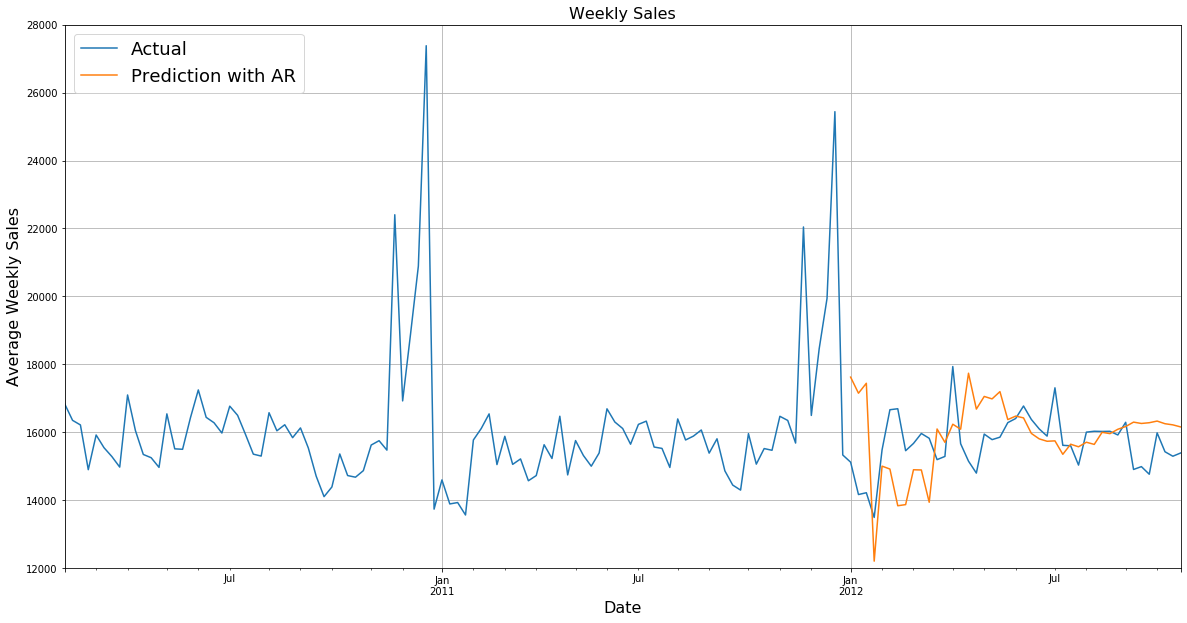

In [7]:
model_ar=AR(train_data)
model_ar_fit=model_ar.fit()
predictions_AR = model_ar_fit.predict(start=100,end=142)


train_final1.Weekly_Sales.plot(figsize=(20,10))
predictions_AR.plot()

plt.legend(['Actual','Prediction with AR'],loc=2,fontsize=18)
plt.grid(True)


plt.title('Weekly Sales',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Average Weekly Sales',fontsize=16)
plt.ylim(12000,28000)

mean_squared_error(test_data['Weekly_Sales'],predictions_AR)

<font size="5">Auto Regressive Integrated Moving Average (ARIMA)</font>

In [8]:
model_ARIMA = pm.auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=52,             # frequency of series
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      start_Q=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False,stationary=True)

print(model_ARIMA.summary())

Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1812.876, BIC=1818.086, Time=0.010 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=1807.819, BIC=1815.634, Time=0.022 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=1806.090, BIC=1816.511, Time=0.028 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=1806.426, BIC=1819.451, Time=0.075 seconds
Fit ARIMA(0,0,4)x(0,0,0,0) [intercept=True]; AIC=1784.615, BIC=1800.246, Time=0.067 seconds
Fit ARIMA(0,0,5)x(0,0,0,0) [intercept=True]; AIC=1783.615, BIC=1801.851, Time=0.289 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=1804.666, BIC=1812.482, Time=0.013 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=1805.371, BIC=1815.792, Time=0.035 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=1807.867, BIC=1820.893, Time=0.051 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=1809.028, BIC=1824.659, Time=0.083 seconds
Fit ARIMA(1,0,4)x(0,0,0,0) [intercept=True]; AIC=1786.168, BIC=1804.404, Time=0.

<font size="5">ARIMA Diagnostics</font>

<Figure size 720x720 with 0 Axes>

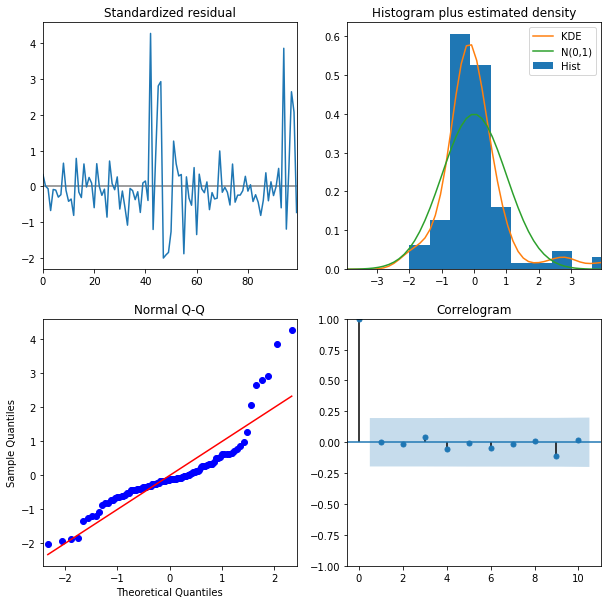

In [9]:
fig=plt.figure(figsize=(10,10))
fig=model_ARIMA.plot_diagnostics(figsize=(10,10))


Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
Top Right: The density plot suggest normal distribution with mean zero.
Bottom left: All the dots should fall perfectly in line with the red line.  #Any significant deviations would imply the distribution is skewed.
Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

<font size="5">Comparison of Actual and Predicted Value from ARIMA</font>

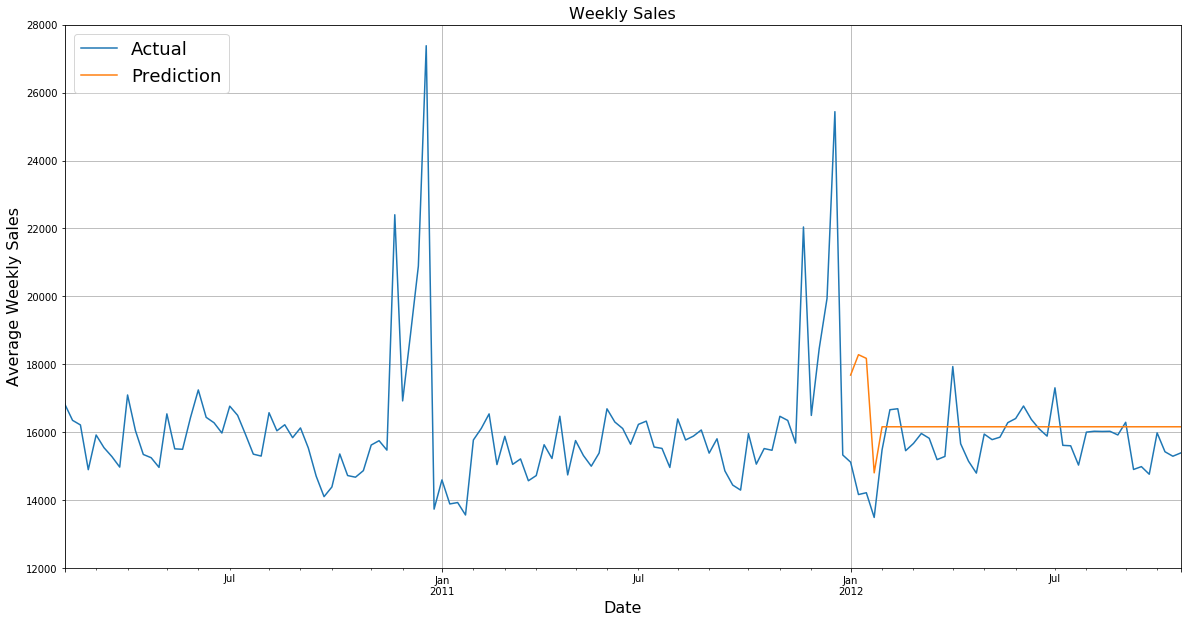

1436452.3934759162

In [10]:
model_ARIMA=ARIMA(train_data,order=(0,0,4))
model_ARIMA_fit=model_ARIMA.fit(disp=-1)

fig,ax=plt.subplots()
ax=train_final1.Weekly_Sales.plot(ax=ax)
predictions_ARIMA=model_ARIMA_fit.predict(start=100,end=142)
predictions_ARIMA.plot(figsize=(20,10))

plt.legend(['Actual','Prediction'],loc=2,fontsize=18)
plt.grid(True)
plt.title('Weekly Sales',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Average Weekly Sales',fontsize=16)
plt.ylim(12000,28000)

plt.show()
mean_squared_error(test_data.Weekly_Sales,predictions_ARIMA)


<font size="5">Seasonal Auto Regressive Integrated Moving Average (SARIMA)</font>

In [11]:
model_SARIMA = pm.auto_arima(train_data,
                           m=52,
                           seasonal=True,
                           d=None, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,staionary=True)


print(model_SARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,52) [intercept=True]; AIC=1775.434, BIC=1796.275, Time=7.361 seconds
Fit ARIMA(0,0,0)x(0,0,0,52) [intercept=True]; AIC=1812.876, BIC=1818.086, Time=0.007 seconds
Fit ARIMA(1,0,0)x(1,0,0,52) [intercept=True]; AIC=1791.092, BIC=1801.512, Time=2.205 seconds
Fit ARIMA(0,0,1)x(0,0,1,52) [intercept=True]; AIC=1762.054, BIC=1772.474, Time=3.446 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,0)x(0,0,0,52) [intercept=False]; AIC=2224.689, BIC=2227.294, Time=0.004 seconds
Fit ARIMA(2,0,2)x(0,0,1,52) [intercept=True]; AIC=1777.152, BIC=1795.388, Time=5.438 seconds
Near non-invertible roots for order (2, 0, 2)(0, 0, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA(2,0,2)x(1,0,0,52) [intercept=True]; AIC=1774.056, BIC=1792.292, Time=6

<font size="5">SARIMA Diagnostics</font>

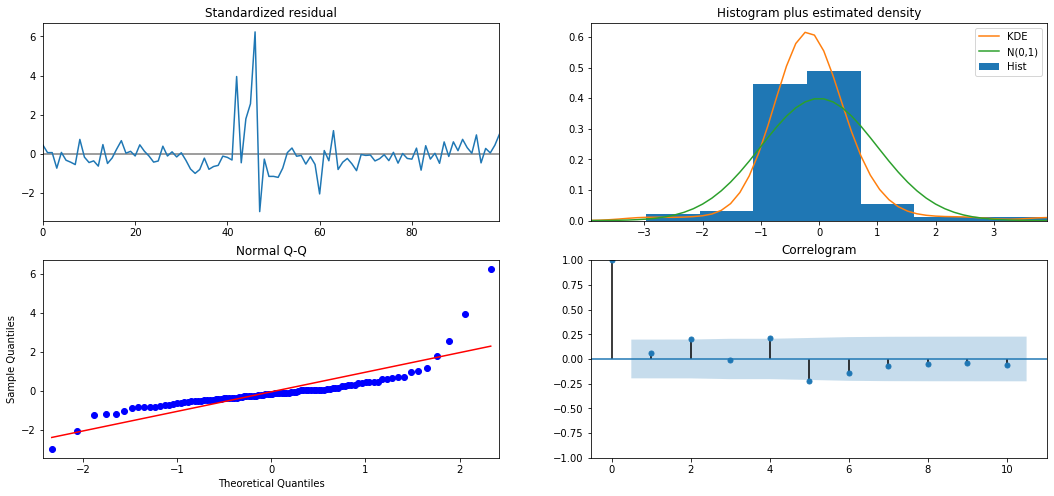

In [12]:
model_SARIMA.plot_diagnostics(figsize=(18, 8))
plt.show()

<font size="5">Comparison of Actual and Predicted Value from SARIMA</font>

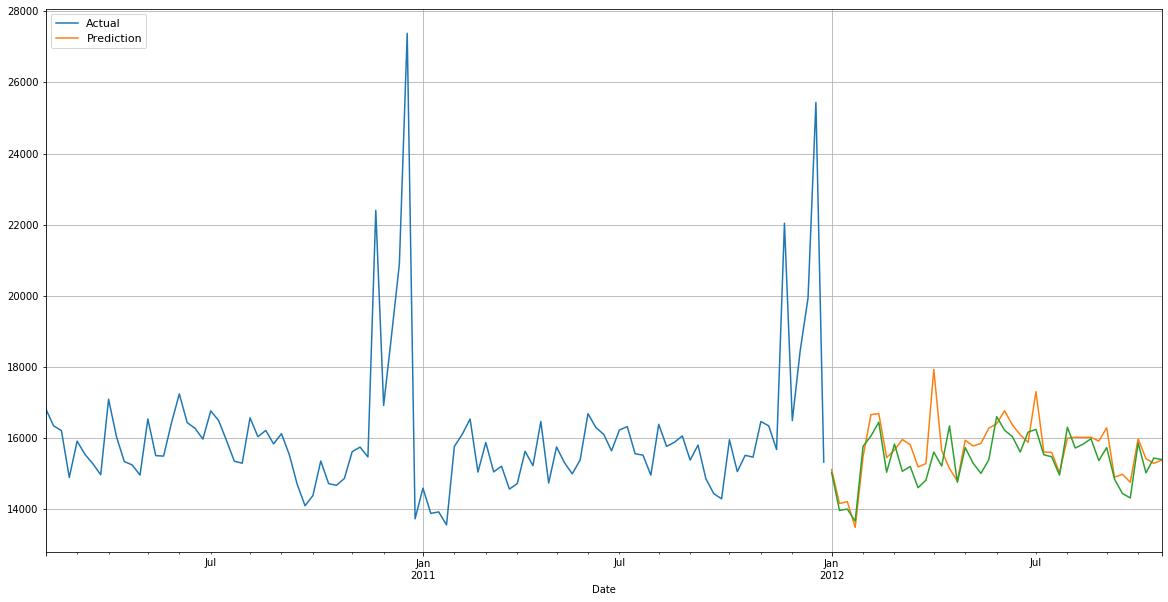

343466.022049742

In [15]:
model_SARIMA = SARIMAX(train_data, order=(1, 0, 2), seasonal_order=(1, 0,1,52))
model_SARIMA_fit = model_SARIMA.fit(disp=False)

fig,ax=plt.subplots()
ax=train_data.plot(ax=ax)
test_data.Weekly_Sales.plot(ax=ax)
predictions_SARIMA=model_SARIMA_fit.predict(start=100,end=142)
predictions_SARIMA.plot(figsize=(20,10))

plt.legend(['Actual','Prediction'],loc=2,fontsize=11)
plt.grid(True)

plt.show()
mean_squared_error(test_data.Weekly_Sales,predictions_SARIMA)


<font size="5">Holt-Winters Method Model</font>

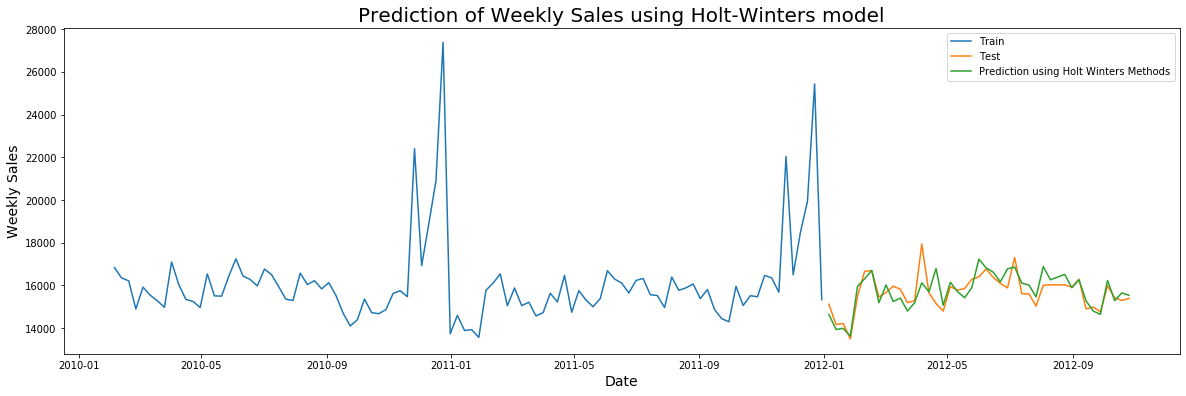

282655.0960050428

In [16]:

model_holt_winters = ExponentialSmoothing(train_data, seasonal_periods=52, trend='mul',seasonal='add').fit() 
prediction_Holt = model_holt_winters.predict(start=100,end=142)# Predict the test data
#Visualize train, test and predicted data.


plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using Holt-Winters model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data.Weekly_Sales, label='Test')
plt.plot(prediction_Holt, label='Prediction using Holt Winters Methods')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

mean_squared_error(test_data.Weekly_Sales,prediction_Holt)